In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
from scipy.stats import norm
import math
import numpy.random as npr
import matplotlib.pyplot as plt
plt.style.use('ggplot')

C:\Users\Chris\anaconda3a\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#Create functions for calculating d1 and d2
def d1(s,k,r,stdev,T):
    value1 = (np.log(s/k) + (r + 0.5*stdev**2)*T) / (stdev*np.sqrt(T))
    return value1
def d2(s,k,r,stdev,T):
    value2 = (np.log(s/k)+(r- 0.5*stdev**2)*T)/(stdev*np.sqrt(T))
    return value2

In [3]:
#Black Scholes Model
def BSM(s,k,r,stdev,T):
    value = (s*norm.cdf(d1(s,k,r,stdev,T))) - (k*np.exp(-r*T)*norm.cdf(d2(s,k,r,stdev,T)))
    return value

## Monte Carlo for European Options

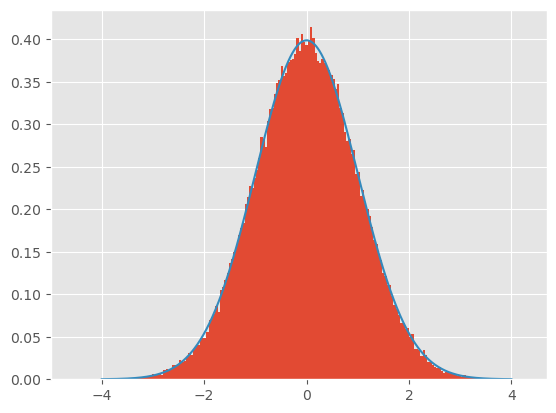

In [4]:
#Stochastic Process (follows Normal Distribution)
#This is an illustration of the stochastic process z

N = 100000
z = npr.standard_normal(N)

z = list(z)
z = pd.DataFrame(z)

plt.hist(z, bins = 200, density=True)
x = np.linspace(-4, 4, 1000)
plt.plot(x, 1 / np.sqrt(2 * np.pi) * np.exp(-x**2/2))
plt.show()


In [5]:
#In a European Call option we only care about the price of the underlying at maturity
#So when valuing a Call using MC, we only simulate the stock at t=T
def EuropeanCallPrice_MC(s,k,r,stdev,T,N):
    
    #Define continuous-time stochastic process z, which follows a normal distribution N(0,t)
    z = npr.standard_normal(N)
    
    #Monte Carlo Simulation at date T for stock s done N times
    ST = s*np.exp(((r-0.5*stdev**2)*T)+stdev*np.sqrt(T)*z)
    
    #Payoff of Call
    payoff = np.maximum(ST-k,0)
    payoff_avg = np.sum(payoff)/N
    
    #use time discounting factor for PV 
    price = np.exp(-r*T)*payoff_avg 
    
    return price

In [6]:
s = 100 #asset price
k = 110 #strike price
r = .05 #risk­free interest rate
stdev = .2 #asset volatility
T = .5 #time to maturity
N = 100000 #number of simulations

BSM(s,k,r,stdev,T)

2.9064713215924165

In [7]:
#parameters
s = 100 #asset price
k = 110 #strike price
r = .05 #risk free interest rate
stdev = .2 #asset volatility
T = .5 #time to maturity
N = 100000 #number of simulations

#Monte Carlo Price
EuropeanCallPriceMC = EuropeanCallPrice_MC(s, k, r, stdev, T, N)

#BlackScholes

CallPriceBS = BSM(s,k,r,stdev,T)

print(f"Call Option Price MC:{CallPriceBS} " )
print(f"Call Option Price MC:{EuropeanCallPriceMC} " )

Call Option Price MC:2.9064713215924165 
Call Option Price MC:2.879205473952221 


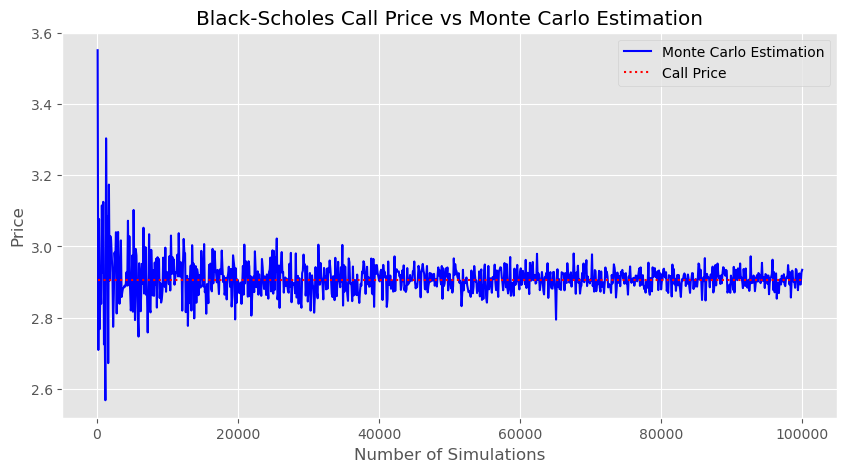

In [8]:
N = 100000 #number of simulations
simu = np.arange(100, N + 100, 100)


CallPriceMC_ = [EuropeanCallPrice_MC(s, k, r, stdev, T, n) for n in simu]

length = len(simu)
plt.figure(figsize=(10, 5))
plt.plot(simu, CallPriceMC_, color = 'blue', label = 'Monte Carlo Estimation')
plt.plot(simu, [CallPriceBS] * length, linestyle = 'dotted', color = 'red', \
         label = 'Call Price')
plt.title('Black­Scholes Call Price vs Monte Carlo Estimation')
plt.xlabel('Number of Simulations')
plt.ylabel('Price')
plt.legend()
plt.show()

## Monte Carlo for Exotic Option Pricing

In [9]:
z = list(z)
z = pd.DataFrame(z)
z[0]

0    0
Name: 0, dtype: int64

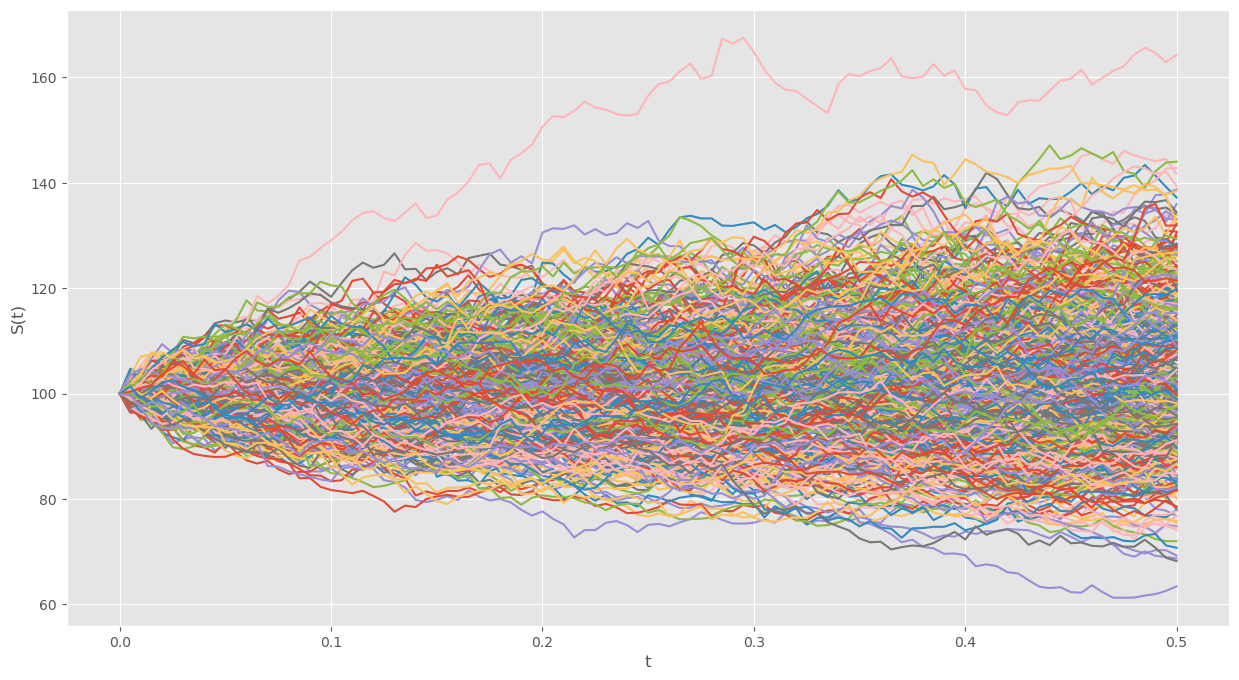

In [10]:
#Simulation of a Geometric Brownian Motion
r = 0.05
stdev = 0.2
s = 100
N = 500 #number of simulations
M = 100 #time steps(number of days)
dt = T / M #time increments

z = stdev*dt**0.5*np.random.randn(M,N)
drift = (r-0.5*stdev**2)*dt

time = np.arange(0,T+dt, dt)
S = np.zeros((M+1, N))
S[0] = s
for i in range(1, M+1):
    S[i] = S[i-1]*np.exp(drift + z[i-1])
    
    
plt.figure(figsize=(15, 8))
plt.plot(time, S[:, :500])
plt.xlabel('t')
plt.ylabel('S(t)')
plt.grid(True)
plt.show()


### Pricing of Geometric Asian Option by Monte Carlo Simulations

In [11]:
#Price of BlackScholes on Asian 
def GeometricAsianCallPrice_BS(s,k,r,stdev,T):
    stdevG = stdev / np.sqrt(3)  #adj volatility for Asian Option
    b = 0.5 * (r - 0.5*stdevG**2) #adj drift rate
    
    d1 = (np.log(s/k)+(b+0.5*stdevG**2)*T) / (stdevG*np.sqrt(T))
    d2 = d1 - stdevG*np.sqrt(T)
    
    n1 = norm.cdf(d1)
    n2 = norm.cdf(d2)
    
    DF = math.exp(-r*T)
    Fb = math.exp((b-r)*T) #Adj factor
    
    price = s*Fb*n1 - k*DF*n2
    
    return price

In [12]:
#Estimation by Monte Carlo Simulations
def GeometricAsianCallPrice_MC(s,k,r,stdev,T,N,M):
    #N = number of simulations, M = number of steps
    dt = T/M #time steps
    
    z = stdev*dt**0.5*np.random.randn(M,N)
    drift = (r-0.5*stdev**2)*dt
    lnS = np.zeros((M+1,N))
    lnS[0] = np.log(s)
    
    for i in range(1, M + 1):
        lnS[i] = lnS[i - 1] + drift + z[i-1]
    
    SGeoMean = np.mean(lnS, axis = 0)
    SGeoMean = np.exp(SGeoMean)
    
    payoff = np.maximum(SGeoMean - k ,0)
    payoff_avg = np.sum(payoff) / N 
    
    price = np.exp(-r * T) * payoff_avg
    return price

In [13]:
#Estimation vs true value

import time

start = time.time()

s = 100
k = 110
r = 0.05
stdev = 0.2
T = 0.5
N = 100000 #num of simulations
M = 100 #num of time steps

GACP_MC = GeometricAsianCallPrice_MC(s, k, r, stdev, T, N, M)
GACP_BS = GeometricAsianCallPrice_BS(s, k, r, stdev, T)

print(f"Geometric Asian Call based on MC: {GACP_MC}")
print(f"Geometric Asian Call based on BS: {GACP_BS}")

end = time.time()

print("Computation Time (in sec): " + str(np.round(end - start, 1)))

Geometric Asian Call based on MC: 0.6481250760917808
Geometric Asian Call based on BS: 0.6543569461936727
Computation Time (in sec): 0.4


In [14]:
s = 100
k = 105
r = .05
stdev = 0.3
T = 1 
N = 100000
M = 100

In [15]:
GACP_MC = GeometricAsianCallPrice_MC(s, k, r, stdev, T, N, M)
GACP_MC

5.342661697583162